# Adaptive Conformal Inference (ACI) under Simulation

In [1]:
import sys
import os
sys.path.append('../src')

from models.ACI import *       # Gibbs & Candes (2021)
from models.agACI import *     # Zaffran et Al. (2022)
from models.dtACI import *     # Gibbs & Candes (2024)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from typing import Callable, Dict, Any
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib as mpl

## Simulate Stationary Data 

In [2]:
# Data Generation Functions

def generate_arma11(T: int, phi: float = 0.8, theta: float = 0.8, sigma: float = 10.0, trend: float = 0) -> np.ndarray:
    y = np.zeros(T)
    noise = np.random.normal(0, sigma, T + 1)
    for t in range(1, T):
        y[t] = phi * y[t - 1] + noise[t] + theta * noise[t - 1] + trend * t
    return y

def generate_ar1(T: int, phi: float = 0.8, sigma: float = 10.0, trend: float = 0) -> np.ndarray:
    y = np.zeros(T)
    noise = np.random.normal(0, sigma, T)
    for t in range(1, T):
        y[t] = phi * y[t - 1] + trend * t + noise[t]
    return y

def generate_ma1(T: int, theta: float = 0.8, sigma: float = 10.0, trend: float = 0) -> np.ndarray:
    noise = np.random.normal(0, sigma, T + 1)
    y = np.zeros(T)
    for t in range(T):
        y[t] = noise[t] + (theta * noise[t - 1] if t > 0 else 0.0) + trend * t
    return y

**Plot**

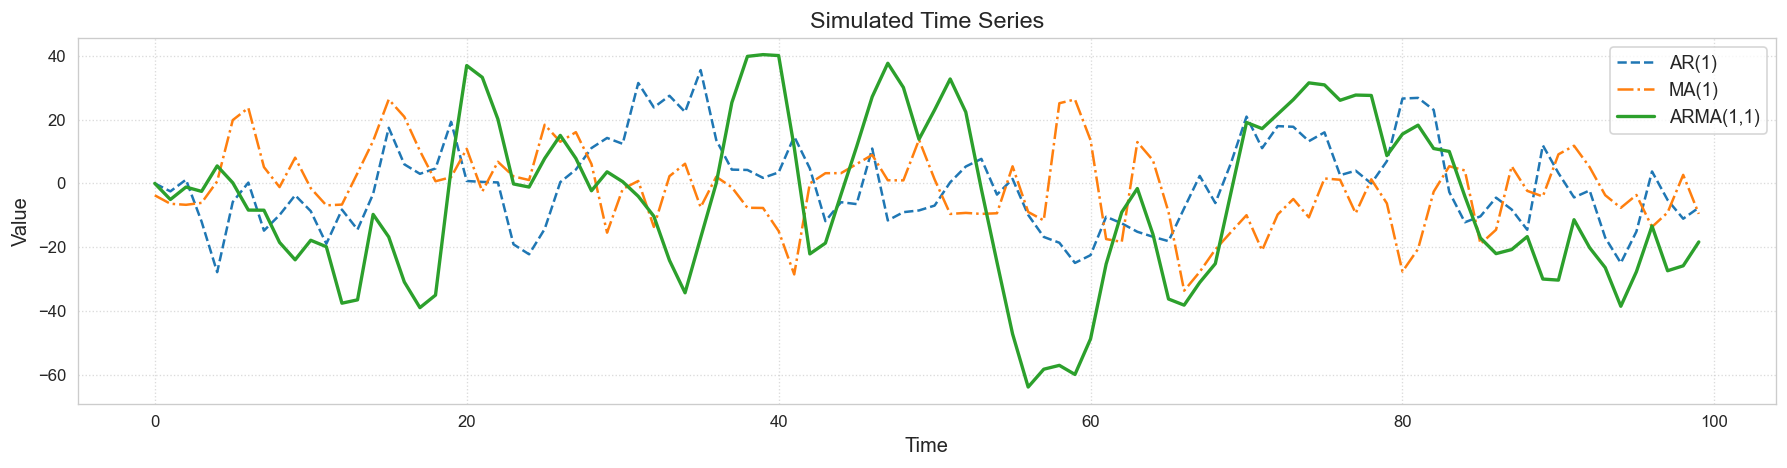

In [3]:
T = 100

sns.set_style("whitegrid")
plt.figure(figsize=(15, 4), dpi=120)
plt.plot(generate_ar1(T), label='AR(1)', linestyle='--', linewidth=1.5)
plt.plot(generate_ma1(T), label='MA(1)', linestyle='-.', linewidth=1.5)
plt.plot(generate_arma11(T), label='ARMA(1,1)', linestyle='-', linewidth=2)

plt.title("Simulated Time Series", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### Simple Oracle Predictors

In [4]:
# Naive Oracle Predictors

def naive_ar1_predict(y: np.ndarray, phi_est: float = 0.8, add_noise: bool = True, noise_sd: float = 0.2) -> np.ndarray:
    T = len(y)
    preds = np.zeros(T)
    preds[0] = y[0]
    for t in range(1, T):
        preds[t] = phi_est * y[t - 1] 
    if add_noise:
        preds += np.random.normal(0, noise_sd, T)
    return preds

def naive_ma1_predict(y: np.ndarray, theta_est: float = 0.8, window: int = 5, add_noise: bool = True, noise_sd: float = 0.2) -> np.ndarray:
    T = len(y)
    preds = np.zeros(T)
    for t in range(T):
        if t < window:
            preds[t] = np.mean(y[:t]) if t > 0 else 0.0
        else:
            preds[t] = np.mean(y[t - window:t])
    if add_noise:
        preds += np.random.normal(0, noise_sd, T)
    return preds

def naive_arma11_predict(y: np.ndarray, phi_est: float = 0.8, theta_est: float = 0.8, add_noise: bool = True, noise_sd: float = 0.2) -> np.ndarray:
    T = len(y)
    preds = np.zeros(T)
    residuals = np.zeros(T)  # Estimated past errors
    preds[0] = y[0]
    for t in range(1, T):
        ar_part = phi_est * y[t - 1] if t > 0 else 0.0
        ma_part = theta_est * residuals[t - 1] if t > 0 else 0.0
        preds[t] = ar_part + ma_part
        residuals[t] = y[t] - preds[t]  # Update residual
    if add_noise:
        preds += np.random.normal(0, noise_sd, T)
    return preds
    

## Online Experiment 

In [5]:
# Online Experiment 

def run_online_experiment(
    method: str,
    dgp_fn: Callable,
    predictor_fn: Callable,
    T: int = 100,
    alpha: float = 0.10,
    n_runs: int = 30,
    gamma: float = 0.01,
    gammas: np.ndarray = None,
    I: int = 30,
    track_adaptations: bool = False,  
    **model_kwargs
) -> Dict[str, np.ndarray]:
    coverages = np.zeros(n_runs)
    median_lengths = np.zeros(n_runs)
    
    # conditional tracking
    alpha_track = coverage_track = residuals_track = [] if track_adaptations else None
    for r in range(n_runs):
        y = dgp_fn(T)
        preds = predictor_fn(y)
        residuals = np.abs(y[:100] - preds[:100]).tolist()

        alpha_t = alpha
        betas, cover_hist, lengths = [], [], []
        alpha_run = coverage_run = residuals_run = [] if track_adaptations else None

        for t in range(100, T):
            # Compute prediction interval using current residual quantile
            sorted_res = np.sort(residuals)
            q_idx = int(np.ceil((1 - alpha_t) * (len(residuals) + 1))) - 1
            q_idx = np.clip(q_idx, 0, len(residuals) - 1)
            radius = sorted_res[q_idx]

            lower, upper = preds[t] - radius, preds[t] + radius
            covered = lower <= y[t] <= upper
            cover_hist.append(covered)
            lengths.append(upper - lower)

            res_t = np.abs(y[t] - preds[t])
            residuals.append(res_t)

            # Update alpha_t using the specified method and accumulated betas
            if method == 'aci':
                beta = int(covered)
                out = aci(np.array(betas + [beta]), alpha, gamma, **model_kwargs)
            elif method == 'agaci':
                beta = np.mean(np.array(residuals[:-1]) <= res_t)
                out = agaci(np.array(betas + [beta]), alpha, gammas, **model_kwargs)
            elif method == 'dtaci':
                beta = np.mean(np.array(residuals[:-1]) <= res_t)
                I_curr = min(I, len(betas) + 1)
                out = dtaci(np.array(betas + [beta]), alpha, gammas, I=I_curr, **model_kwargs)
            else:
                raise ValueError('Unknown method')

            betas.append(beta)
            alpha_t = out['alphaSeq'][-1]
            
            if track_adaptations:
                alpha_run.append(alpha_t)
                coverage_run.append(covered)
                residuals_run.append(res_t) 

        coverages[r] = np.mean(cover_hist)
        median_lengths[r] = np.median(lengths)
        
        if track_adaptations:
            alpha_track.append(alpha_run)
            coverage_track.append(coverage_run)
            residuals_track.append(residuals_run)

    result = {
        'mean_coverage': coverages.mean(),
        'std_coverage': coverages.std(),
        'mean_median_length': median_lengths.mean(),
        'std_median_length': median_lengths.std(),
    }
    
    # Include tracks in result only if enabled
    if track_adaptations:
        result['alpha_track'] = np.array(alpha_track)
        result['coverage_track'] = np.array(coverage_track)
        result['residuals_track'] = np.array(residuals_track)
    
    return result


# Experiment
def run_comprehensive_experiment(
    phi_values=[0.1, 0.8, 0.9, 0.95, 0.99],
    gamma_values=[0.01, 0.05],
    gamma_grid=np.array([0.001, 0.05, 0.1]),
    n_runs=10,
    alpha=0.10,
    T=300,
    I=30
):
    process_configs = {
        "AR1": lambda phi: (
            lambda T_val: generate_ar1(T_val, phi=phi),
            lambda y: naive_ar1_predict(y, phi_est=phi)
        ),
        "MA1": lambda phi: (
            lambda T_val: generate_ma1(T_val, theta=phi),
            lambda y: naive_ma1_predict(y, theta_est=phi)
        ),
        "ARMA11": lambda phi: (
            lambda T_val: generate_arma11(T_val, phi=phi, theta=phi),
            lambda y: naive_arma11_predict(y, phi_est=phi, theta_est=phi)
        )
    }

    
    results = {name: {} for name in process_configs}
    total_experiments = len(phi_values) * len(process_configs) * (len(gamma_values) + 2)
    pbar = tqdm(total=total_experiments, desc="Simulation Progress")
    
    for process_name, config_fn in process_configs.items():
        process_results = {}
        for phi in phi_values:
            dgp_fn, predictor = config_fn(phi)

            # ACI runs (for each gamma)
            phi_results = {}
            for gamma in gamma_values:
                key = f"ACI_{gamma}"
                phi_results[key] = run_online_experiment(
                    method='aci', dgp_fn=dgp_fn, predictor_fn=predictor, T=T, alpha=alpha, n_runs=n_runs, gamma=gamma
                )
                pbar.update(1)
                
            # AgACI run
            key = "AgACI"
            phi_results[key] = run_online_experiment(
                method='agaci', dgp_fn=dgp_fn, predictor_fn=predictor, T=T, alpha=alpha, n_runs=n_runs, gammas=gamma_grid
            )
            pbar.update(1)
            
            # DTACI run
            key = "DtACI"
            phi_results[key] = run_online_experiment(
                method='dtaci', dgp_fn=dgp_fn, predictor_fn=predictor, T=T, alpha=alpha, n_runs=n_runs, gammas=gamma_grid, I=I
            )
            pbar.update(1)
            process_results[phi] = phi_results
            
        results[process_name] = process_results
    pbar.close()
    
    return results

# Run and Plot
experiment_results = run_comprehensive_experiment(n_runs=200)

Simulation Progress:   0%|          | 0/60 [00:00<?, ?it/s]

c:\Users\Csome\A.Notebooks\Thesis\conformal_forecasting\notebooks\../src\models\agACI.py:93: RuntimeWarning: divide by zero encountered in divide
  expert_etas = np.minimum(1 / expert_evals, np.sqrt(np.log(k) / expert_sq_losses))


In [55]:
def plot_results(results, alpha=0.10):

    plt.rcParams.update({
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
        'text.usetex': False,
        'font.size': 11,
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11,
        'legend.title_fontsize': 11
    })

    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=1)

    methods = ['ACI_0.01', 'ACI_0.05', 'AgACI', 'DtACI']
    markers = {'ACI_0.01': 'D', 'ACI_0.05': 'd', 'AgACI': '*', 'DtACI': 'o'}
    methods_display = {
        'ACI_0.01': r'ACI (Gibbs & Candès, 2021), $\gamma=0.01$',
        'ACI_0.05': r'ACI (Gibbs & Candès, 2021), $\gamma=0.05$',
        'AgACI': 'AgACI (Zaffran et Al., 2022)',
        'DtACI': 'DtACI (Gibbs & Candès, 2024)'
    }
    colors = ['#c6dbef', '#9ecae1', '#6baed6', '#3182bd', '#08519c']

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    axes_dict = dict(zip(['ARMA11', 'AR1', 'MA1'], axes))
    title_map = {'ARMA11': 'ARMA(1,1)', 'AR1': 'AR(1)', 'MA1': 'MA(1)'}
    phi_values = sorted(next(iter(results.values())).keys())

    marker_size = 110

    for process_name, ax in axes_dict.items():
        process_results = results[process_name]
        for idx, phi in enumerate(phi_values):
            phi_results = process_results[phi]
            for method in methods:
                metrics = phi_results[method]
                mean_cov = metrics['mean_coverage']
                mean_len = metrics['mean_median_length']

                ax.scatter(mean_cov, mean_len, marker=markers[method], color=colors[idx],
                           s=marker_size, edgecolor='black', linewidth=0.8, alpha=0.9)

        ax.axvline(x=1 - alpha, color='black', linestyle=':', linewidth=1)
        ax.set_xlabel("Coverage")
        ax.set_ylabel("Avg. Median Width")
        ax.set_title(title_map.get(process_name, process_name), fontsize=20)
        ax.grid(True, linestyle='--', alpha=0.5)

    # Methods legend
    handles_methods = [mlines.Line2D([], [], color='black', marker=markers[m], linestyle='None', markersize=12,
                                     label=methods_display[m]) for m in methods]

    # Phi values legend
    handles_phi = [mlines.Line2D([], [], color=colors[idx], marker='o', linestyle='None', markersize=12,
                                 label=fr'$\varphi = \theta = {phi}$') for idx, phi in enumerate(phi_values)]

    plt.subplots_adjust(top=0.82, right=0.82)

    fig.legend(handles_methods, [h.get_label() for h in handles_methods],
               loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=2, frameon=True)

    fig.legend(handles_phi, [h.get_label() for h in handles_phi],
               loc='center right', bbox_to_anchor=(0.92, 0.6), frameon=True, title="Noise Parameters", title_fontsize=14)

    plt.savefig('adaptive_conformal_results_publication.pdf', bbox_inches='tight', dpi=300, format='pdf')
    plt.show()


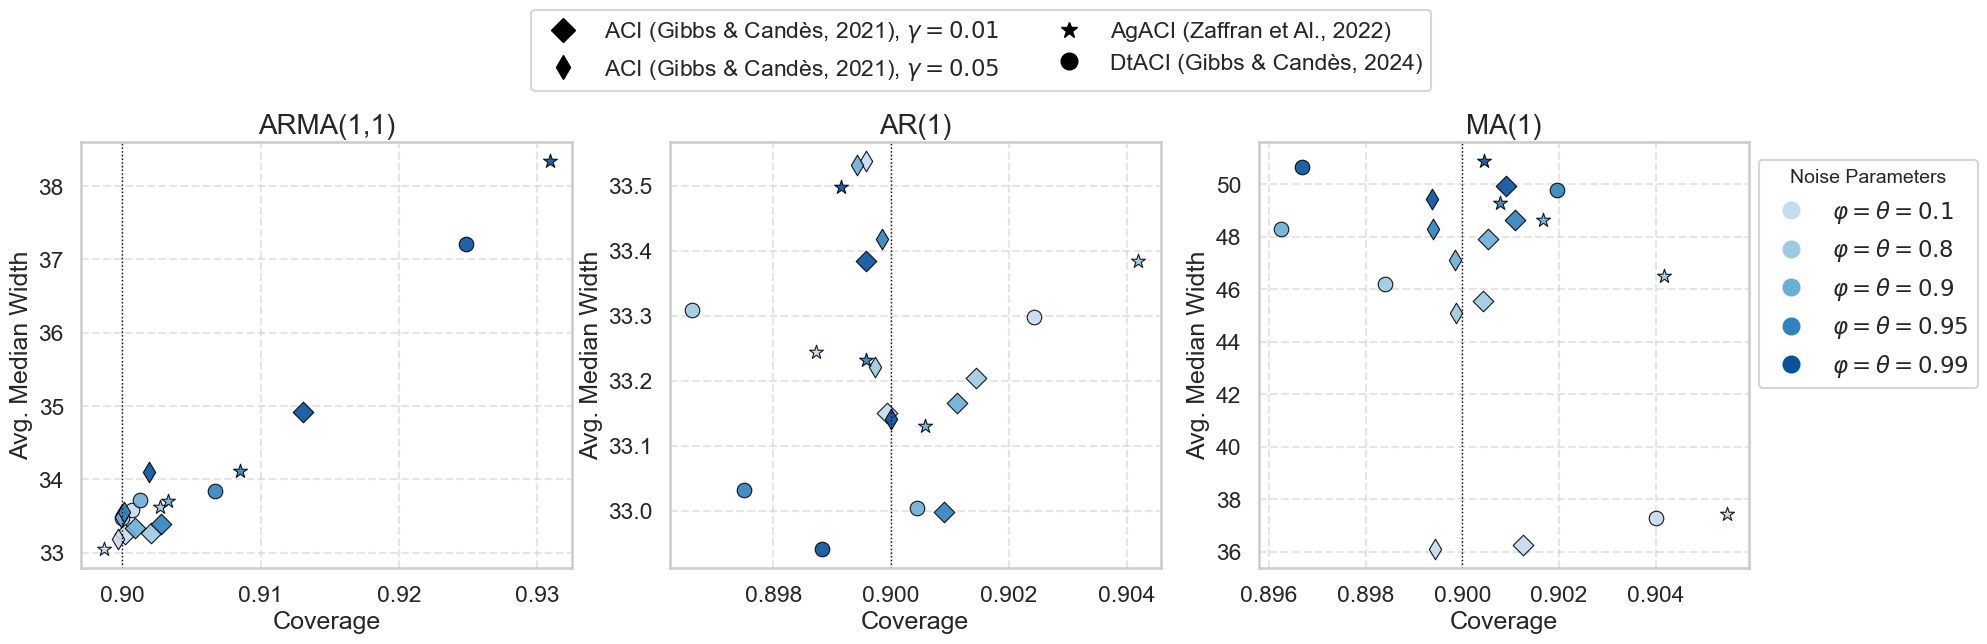

In [56]:
plot_results(experiment_results)